# **Intel Image Classification**

The purpose of this notebook is to train a Deep Learning model with the help of Convolutional Neural Networks. Specifically, we are going to train a model which will solve an Image Classification problem.




In [ ]:
import jovian
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset, Subset
import torchvision.models as models
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle
#Check the present working directory using pwd command

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

intel-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

### **About the Dataset**

In this case, we have chosen the "Intel Image Classification" dataset, which contains image data of Natural Scenes around the world.

These image data include around 25k images distributed under 6 categories: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In addition, these images are split into three categories : 14k images in Train, 3k in Test and 7k in Prediction.

**Dataset Link:** https://www.kaggle.com/puneet6060/intel-image-classification

Let's load the data as Pytorch Tensor

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize


train_ds = ImageFolder('./seg_train/seg_train', transform=Compose([Resize((160, 160)),ToTensor()]))

test_ds = ImageFolder('./seg_test/seg_test', transform=Compose([Resize((160, 160)),ToTensor()]))

classes = train_ds.classes

classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
print('Size train dataset: ' , len(train_ds))

Size train dataset:  14034


In [ ]:
print('Size test dataset: ', len(test_ds))

Size test dataset:  3000


## **Sample Images**

In [ ]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  buildings (0)


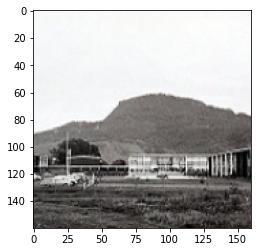

In [ ]:
show_example(*train_ds[0])

Label:  glacier (2)


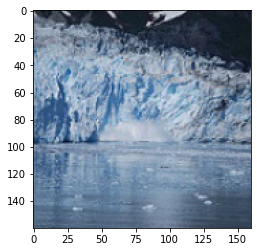

In [ ]:
show_example(*train_ds[5000])

Label:  sea (4)


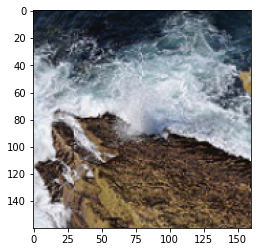

In [ ]:
show_example(*train_ds[10000])

## **Data Loaders**

Now we are going to create data loaders for training and validation, to load the image data in batches.

In [ ]:
from torch.utils.data.dataloader import DataLoader

batch_size=64

val_size = 1000
train_size = len(train_ds) - val_size

train_ds, val_ds = random_split(train_ds, [train_size, val_size])
len(train_ds), len(val_ds)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

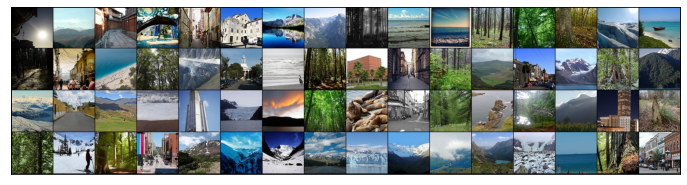

In [ ]:
show_batch(train_dl)

## **Intel Image Classification Model**

In [ ]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class IntelCnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 64 x 80 x 80
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 128 x 40 x 40
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 256 x 20 x 20
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Output size: 512 x 10 x 10
            
            nn.Flatten(),
            nn.Linear(512*10*10, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 6))
        
    def forward(self, xb):
        return self.network(xb)


In [ ]:
model = IntelCnnModel()
model

IntelCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16): ReLU()
    (17): Conv2d(512, 512, kernel_size=(3, 3), stride=(1

## **Use of GPU**

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
print(device)

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

cuda


In [ ]:
to_device(model, device);

## **Training the Model**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([64, 3, 160, 160])
out.shape: torch.Size([64, 6])


In [ ]:
evaluate(model, val_dl)

{'val_acc': 0.15940505266189575, 'val_loss': 1.7975163459777832}

In [ ]:
opt_func = torch.optim.Adam
num_epochs = 8

In [ ]:
history = fit(num_epochs, 0.0001, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 1.0876, val_acc: 0.5671
Epoch [1], val_loss: 0.9359, val_acc: 0.6281
Epoch [2], val_loss: 0.8671, val_acc: 0.6701
Epoch [3], val_loss: 0.7721, val_acc: 0.6920
Epoch [4], val_loss: 0.7810, val_acc: 0.7092
Epoch [5], val_loss: 0.7042, val_acc: 0.7470
Epoch [6], val_loss: 0.6279, val_acc: 0.7665
Epoch [7], val_loss: 0.6328, val_acc: 0.7711


In [ ]:
history = fit(num_epochs, 0.00001, model, train_dl, val_dl, opt_func)

Epoch [0], val_loss: 0.5543, val_acc: 0.7882
Epoch [1], val_loss: 0.5447, val_acc: 0.8089
Epoch [2], val_loss: 0.5446, val_acc: 0.8006
Epoch [3], val_loss: 0.5500, val_acc: 0.8126
Epoch [4], val_loss: 0.5369, val_acc: 0.8076
Epoch [5], val_loss: 0.5489, val_acc: 0.8106
Epoch [6], val_loss: 0.5478, val_acc: 0.8064
Epoch [7], val_loss: 0.5412, val_acc: 0.8040


## **Saving the Model** 

In [ ]:
torch.save(model.state_dict(), 'intel-image-classification.pth')

In [ ]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': [8,8],
    'opt_func': opt_func.__name__,
    'batch_size': batch_size,
    'lr': [0.0001, 0.00001],
})

[jovian] Hyperparams logged.


In [ ]:
jovian.log_metrics(val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


## **Predictions on Samples**

In [ ]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return test_ds.classes[preds[0].item()]

Label: buildings , Predicted: buildings


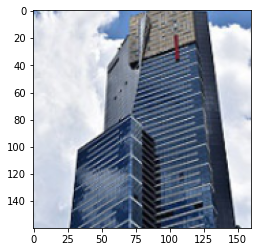

In [ ]:
img, label = test_ds[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: glacier , Predicted: glacier


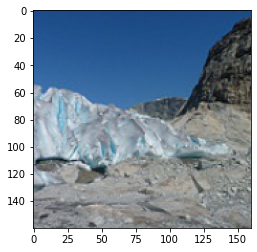

In [ ]:
img, label = test_ds[1200]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

Label: sea , Predicted: sea


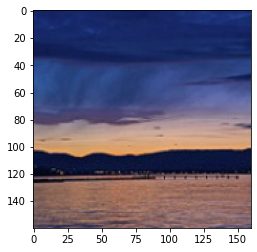

In [ ]:
img, label = test_ds[2240]
plt.imshow(img.permute(1, 2, 0))
print('Label:', test_ds.classes[label], ', Predicted:', predict_image(img, model))

In [ ]:
test_dl = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)
evaluate(model, test_dl)

{'val_acc': 0.8110119700431824, 'val_loss': 0.5545625686645508}

## **Conclusions**

*   In this notebook we have trained a Deep Learning Model with Convolutional Neural Networks with an accuracy of 81,1%.

*   Despite we have achieved high accuracy with our model, we could improve it applying techniques of data normalization, data augmentation or regularization, since with these, we would have a strong likelihood of getting more than 90% of accuracy.







